In [102]:
#Importing the basic librarires

import os
import math
import scipy
from time import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

import sklearn.metrics as metrics

from mpl_toolkits.mplot3d import Axes3D # 3d plot
from termcolor import colored as cl

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

# 1. Data Exploration

In [2]:
df=pd.read_excel('C:\\Users\\david\\Desktop\\Online Retail.xlsx')

original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



Inference: The Datset consists of 8 features & 541909 samples.


In [3]:
df_s = df.sample(10000, random_state=42)
df_s["InvoiceDate"] = df_s["InvoiceDate"].dt.date
df_s["TotalSum"] = df_s["Quantity"] * df_s["UnitPrice"]
snapshot_date = max(df_s.InvoiceDate) + datetime.timedelta(days=1)
customers = df_s.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                            'InvoiceNo': 'count','TotalSum': 'sum'})
customers.rename(columns = {'InvoiceDate': 'Recency','InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)
#customers = customers[customers.MonetaryValue>0]
display(customers.head())

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,3,5,81.60
12349.0,19,1,19.90
12353.0,205,1,39.80
12354.0,233,2,25.45
12356.0,326,1,50.00


In [4]:
#Checking the dtypes of all the columns

customers.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2433 entries, 12347.0 to 18287.0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        2433 non-null   int64  
 1   Frequency      2433 non-null   int64  
 2   MonetaryValue  2433 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 76.0 KB


In [5]:
#Checking the stats of all the columns

display(customers.describe())

,Recency,Frequency,MonetaryValue
count,2433.000000,2433.000000,2433.000000
mean,115.114673,3.076038,60.757185
std,105.746852,5.693838,205.094177
min,1.000000,1.000000,-1867.860000
25%,30.000000,1.000000,12.400000
50%,73.000000,2.000000,24.770000
75%,191.000000,3.000000,53.100000
max,374.000000,137.000000,4887.330000


# 2. Exploratory Data Analysis (EDA)

                                   RMF Variables Distribution                                   


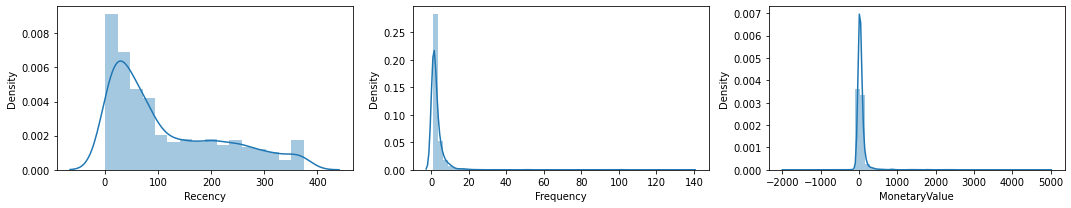

In [12]:
#Understanding the RFM Distribution

print('\033[1mRMF Variables Distribution'.center(100))

n=3
nf = [i for i in customers.columns]

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n),n,c+1)
    sns.distplot(customers[nf[c]])
plt.tight_layout()
plt.show()

Inference: The data does not meet the assumptions where the variables are not squewed and have same mean & variance. Let us try to transform the data. Some of the common transorms are:

Log Transform
Sqrt Trasform
Box-Cox Transform

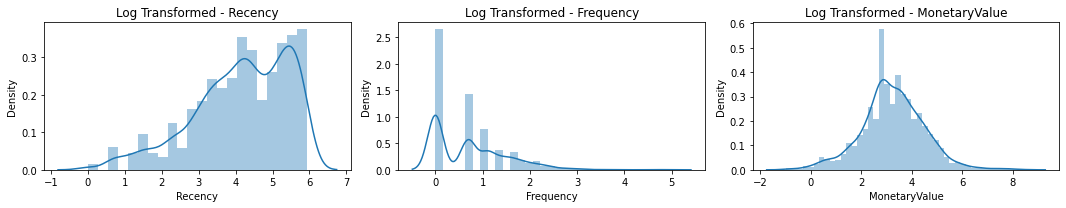

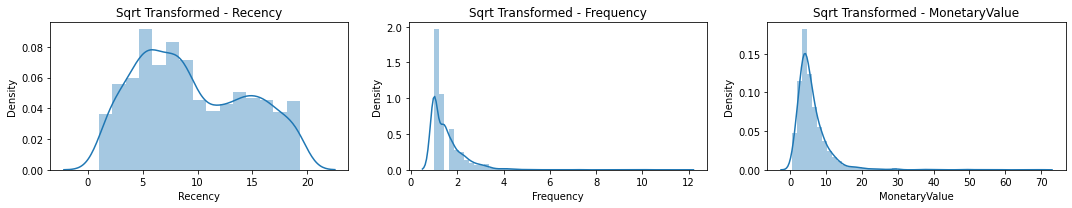

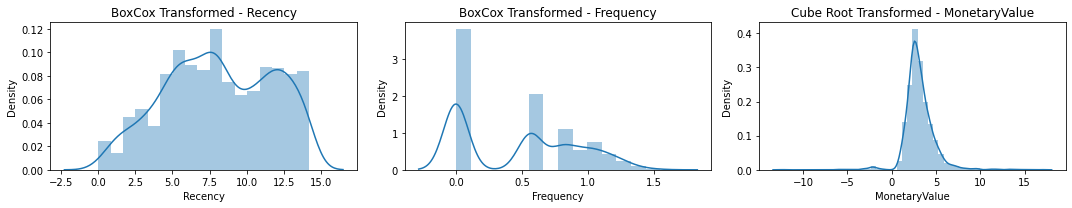

In [13]:
cutomers_logT = customers.copy(deep=True)
cutomers_sqrtT = customers.copy(deep=True)
cutomers_cbrtT = customers.copy(deep=True)
cutomers_bxcxT = customers.copy(deep=True)

for i in customers.columns:
    cutomers_logT[i] = np.log(customers[i])
    cutomers_sqrtT[i] = np.sqrt(customers[i])
    cutomers_cbrtT[i] = np.cbrt(customers[i])
    if i!='MonetaryValue':
        cutomers_bxcxT[i] = stats.boxcox(customers[i])[0]

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n),n,c+1)
    sns.distplot(cutomers_logT[nf[c]])
    plt.title('Log Transformed - {}'.format(nf[c]))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n),n,c+1)
    sns.distplot(cutomers_sqrtT[nf[c]])
    plt.title('Sqrt Transformed - {}'.format(nf[c]))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for c in range(len(nf)-1):
    plt.subplot(1,3,c+1)
    sns.distplot(cutomers_bxcxT[nf[c]])
    plt.title('BoxCox Transformed - {}'.format(nf[c]))
plt.subplot(1,3,3)
sns.distplot(cutomers_cbrtT[nf[2]])
plt.title('Cube Root Transformed - {}'.format(nf[2]))
plt.tight_layout()
plt.show()

Inference: By overserving the plots, it is clear that Recency & Frequency shows more symmetrical form with box-cox transform. Since Monetart Value cannot be represented with Box-cox as it contains negative values, hence we shall use cube root transformation for it.

# 3. Data Preprocessing

In [14]:
#Applying the selected Transformations

customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2428,5.144506,1.021167,4.861252
2429,6.148622,0.564199,4.091635
2430,1.272970,0.798349,3.737290
2431,1.671379,1.253008,3.013275
2432,11.514709,0.000000,2.482545


# 4. Data Manipulation

In [15]:
#Applying Standardization

scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[-0. -0. -0.]
[1. 1. 1.]


# 5. Predictive Modeling

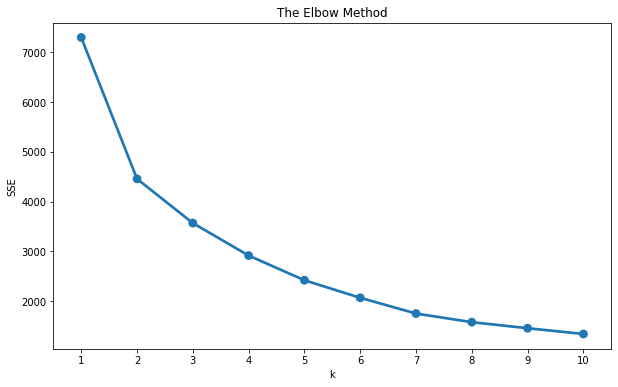

In [16]:
# Building KMeans Algorithm on the dataset

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

#Elbow Plot    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

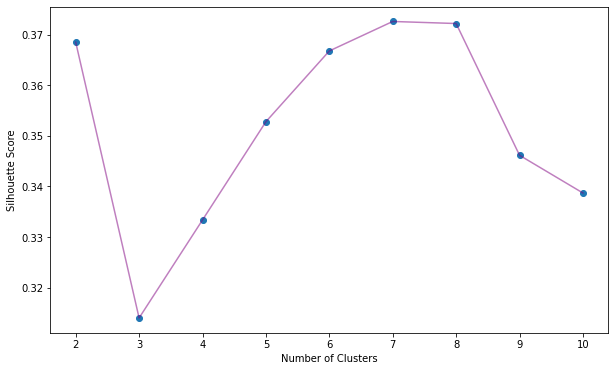

In [27]:
# Calculate silhouette score
# Full dataset
sil = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    predict=kmeans.fit_predict(customers_normalized)
    score = silhouette_score(X = customers_normalized, labels = predict)
    sil.append(score)
    
plt.plot(np.arange(2 , 11) , sil , 'o', label = "")
plt.plot(np.arange(2 , 11) , sil , '-' , alpha = 0.5, color = 'purple')
plt.xlabel('Number of Clusters') , plt.ylabel('Silhouette Score')
plt.show()

In [66]:
#Final Model

model = KMeans(n_clusters=5, random_state=42)
model.fit(customers_normalized)

customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         41.06     10.22        341.33   242
1        175.85      2.77         43.70   547
2         29.11      3.95         39.61   621
3        242.43      1.02         14.28   548
4         48.45      1.01         18.72   475

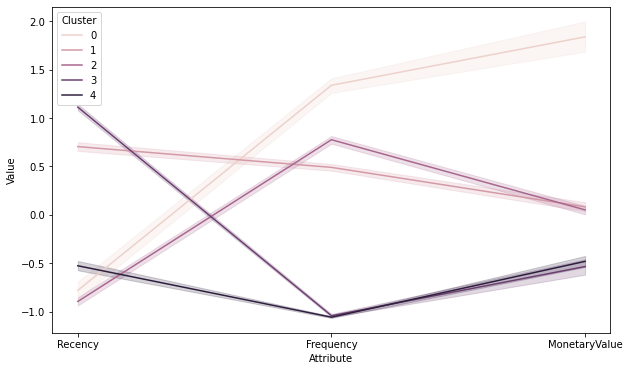

In [67]:
# Visualising the Cluster Chartecteristics

df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)
plt.show()

Insights: By using this plot, we know how each segment differs. It describes more than we use the summarized table. We infer that cluster 0 is frequent, spend more, and they buy the product recently. Therefore, it could be the cluster of a loyal customer. Then, the cluster 1 is less frequent, less to spend, but they buy the product recently. Therefore, it could be the cluster of new customer. Finally, the cluster 2 is less frequent, less to spend, and they buy the product at the old time. Therefore, it could be the cluster of churned customers.

Here are some of the key outcomes of the project:
The Dataset was large enough summing around 5.4 lakh samples & we used a 10k subsamples for creation of the model.
For the segmentation we used RMF Technique to create working table as it is most common segmentation technique.
Visualising the distribution of data & their relationships, helped us to get some insights on the relationship between the feature-set.
Appropriate Transformations were applied on the data to satisfy the key assumptions. Followed by Standardization.
K Means algorithm was applied and appropriate cluster number was selected using Elbow Plot.
The results were interepreted by calculating the cluster means & it was visualised with help of snake plot.

In [74]:
def drawCluster2D(df):
    area = np.pi * (df.Frequency) ** 4

    sns.scatterplot('Recency', 'MonetaryValue', 
                   data = df, 
                   s = area, 
                   hue = 'Cluster', 
                   palette = 'spring', 
                   alpha = 0.6, 
                   edgecolor = 'darkgrey')
    plt.title('Recency / MonetaryValue (CLUSTERED)', 
              fontsize = 18)
    plt.xlabel('Recency', 
               fontsize = 16)
    plt.ylabel('MonetaryValue', 
               fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(loc = 'lower left', fontsize = 14)

    plt.savefig('2d_plot.png')
    plt.show()

In [71]:
def drawCluster3D(df):
    fig = plt.figure(1)
    plt.clf()
    ax = Axes3D(fig, 
                rect = [0, 0, .95, 1], 
                elev = 48, 
                azim = 134)

    plt.cla()
    ax.scatter(df['MonetaryValue'], df['Recency'], df['Frequency'], 
               c = df_normalized['Cluster'], 
               s = 200, 
               cmap = 'spring', 
               alpha = 0.5, 
               edgecolor = 'darkgrey')
    ax.set_xlabel('MonetaryValue', 
                  fontsize = 16)
    ax.set_ylabel('Recency', 
                  fontsize = 16)
    ax.set_zlabel('Frequency', 
                  fontsize = 16)

    plt.savefig('3d_plot.png')
    plt.show()

In [115]:
def benchCluster(estimator, name, data):
   t0 = time()
   estimator.fit(data)
   print('Name: % 9s Time:%.2fs Inertia:%i Davies Bouldin score:%.3f Calinski harabasz score:%.3f Silhouette score%.3f'
      % (name, 
         (time() - t0), 
         estimator.inertia_,
         metrics.davies_bouldin_score(data, estimator.labels_),
         metrics.calinski_harabasz_score(data, estimator.labels_),
         metrics.silhouette_score(data, estimator.labels_, metric='euclidean',sample_size=300)))

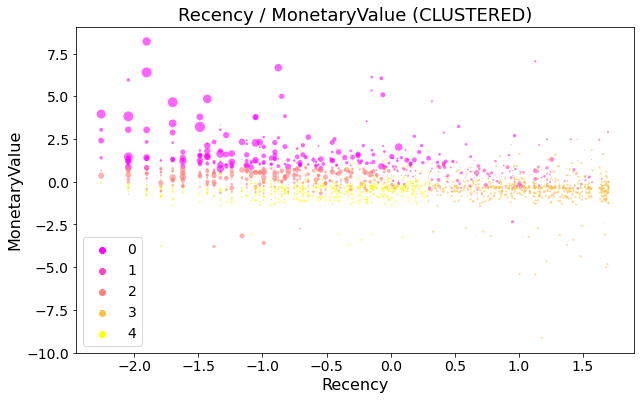

In [75]:
drawCluster2D(df_normalized)

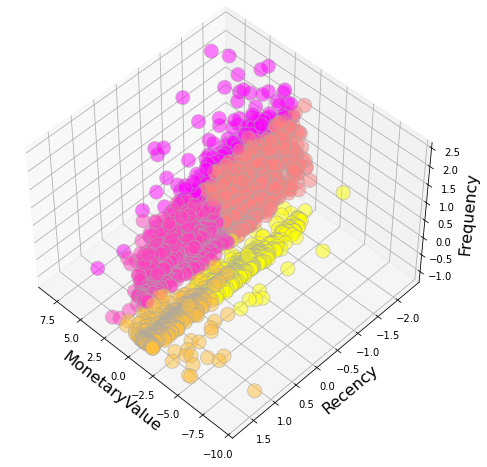

In [76]:
drawCluster3D(df_normalized)

In [98]:
# Use mini-batch k-means
model = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=100)
model.fit(customers_normalized)

customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

Name: mini-batch k-means Time:0.10s Inertia:2429 Davies Bouldin score:0.977 Calinski harabasz score:1219.029 Silhouette score:0.354


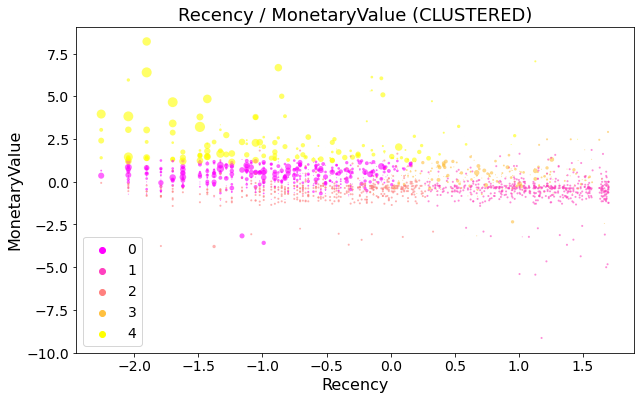

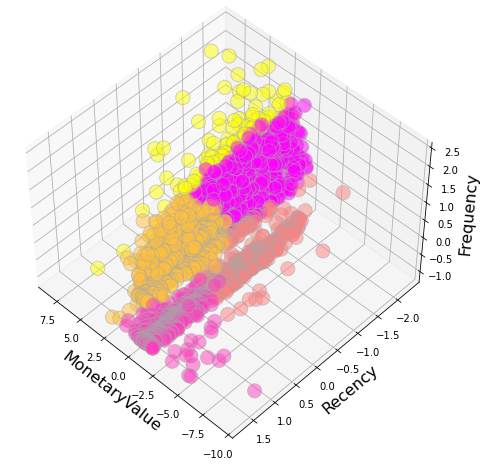

In [116]:
benchCluster(model, "mini-batch k-means", customers_normalized)
drawCluster2D(df_normalized)
drawCluster3D(df_normalized)

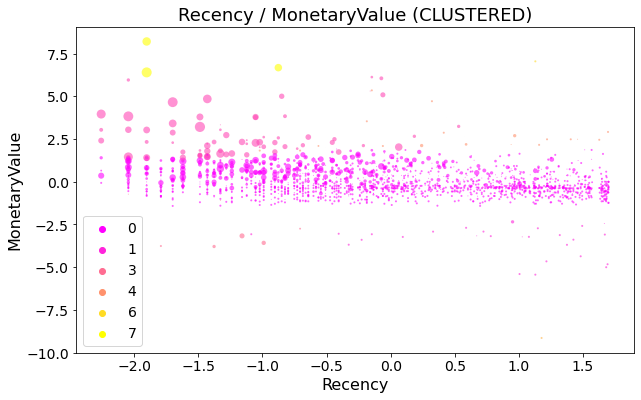

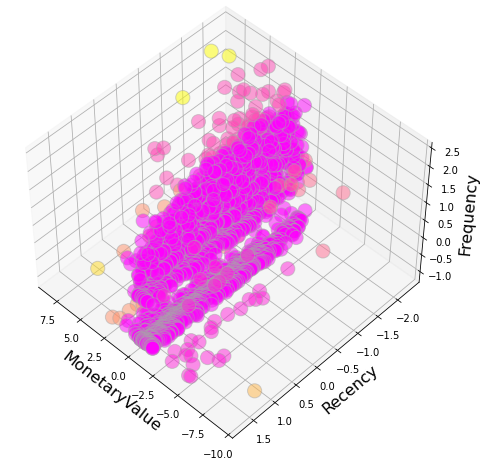

In [118]:
# Use meanshift clustering

model = MeanShift(n_jobs=-1)
model.fit(customers_normalized)

customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

drawCluster2D(df_normalized)
drawCluster3D(df_normalized)

Silhouette score - DBSCAN:  0.22928092329257704


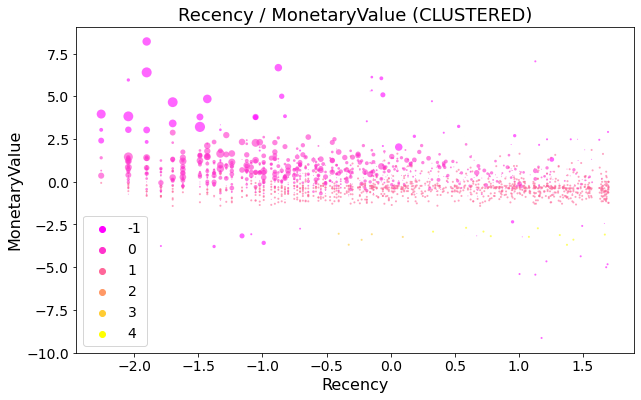

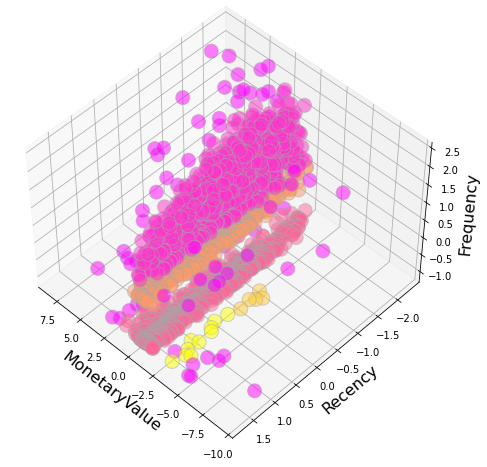

In [95]:
# Use DBSCAN clustering

model = DBSCAN(n_jobs=-1)
model.fit(customers_normalized)

customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

model = DBSCAN(n_jobs=-1)
predict = model.fit_predict(customers_normalized)
score = silhouette_score(X = customers_normalized, labels = predict)
    
print('\033[1mSilhouette score - DBSCAN: ', score)
drawCluster2D(df_normalized)
drawCluster3D(df_normalized)

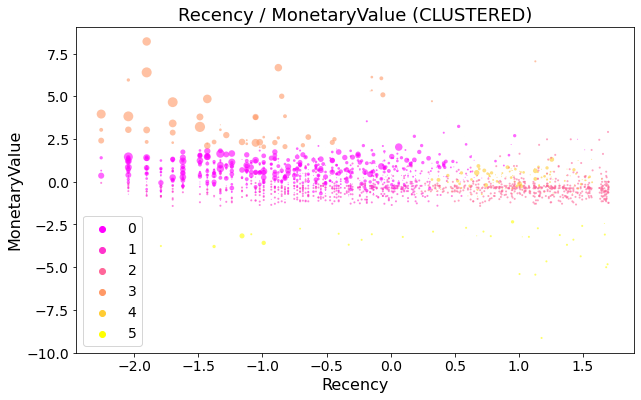

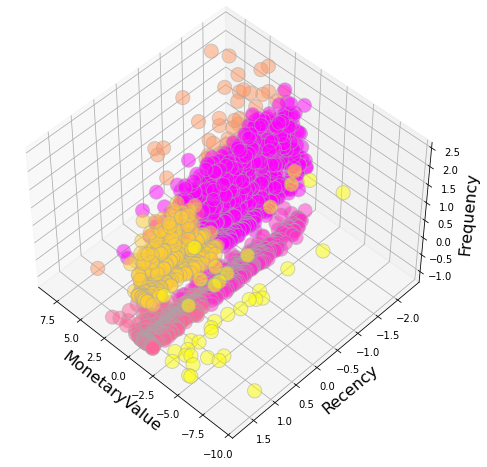

In [121]:
# Use AgglomerativeClustering clustering

model = AgglomerativeClustering(n_clusters=6)
model.fit(customers_normalized)

customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

drawCluster2D(df_normalized)
drawCluster3D(df_normalized)